In [1]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import os
import json
from matplotlib.colors import LinearSegmentedColormap

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', 1000)

In [2]:
MATERIAL_PATH = "../All_mat_new_test_score_with_horz_flat_index.csv"
#DATA_PATH = "../../data"

# "henry's local data path"
DATA_PATH = "../../MPhys_Project/data extraction+fingerprinting/FULL_MATPEDIA_DATA"

## Start with Anupam's list of materials

In [3]:
material_df = pd.read_csv("../All_mat_new_test_score_with_horz_flat_index.csv", index_col="ID")
print(material_df.shape)
material_df.head()

(5270, 24)


,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,decomp_eng,band_gap,point_group,crystal,A,B,C,D,E,F,radio,f_orb,sg_sto_group,percentage_flat
ID,,,,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,0.799800,0.0000,-3m,trigonal,F,Ir,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,0.300020,0.0000,-3m,trigonal,Ba,Sb,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,0.177410,0.9814,-1,triclinic,S,Tl,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,0.485820,0.0000,2/m,trigonal,Cl,Mo,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,0.011699,1.1619,-3m,trigonal,I,Ru,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN


In [16]:
# Select flat materials only
flat_df = material_df[material_df.horz_flat_seg > 0]
flat_df.shape

(2005, 24)

## Fingerprint Functions Here
Fingerprint functions take material ID as only input

array([ 0.,  0.,  6., 48., 14., 18., 21.,  5.,  3.,  2., 10., 12., 25.,
       21., 23., 21., 25., 27., 33., 35.,  0.,  0.,  0., 63., 18., 15.,
        9.,  0.,  0.,  0.,  0., 12.,  9., 11., 24., 14., 34., 79., 63.,
       53.,  0.,  0.,  6., 46., 18.,  6., 31.,  6.,  3.,  3., 11., 15.,
       24., 26., 25., 24., 29., 21., 26., 30.])

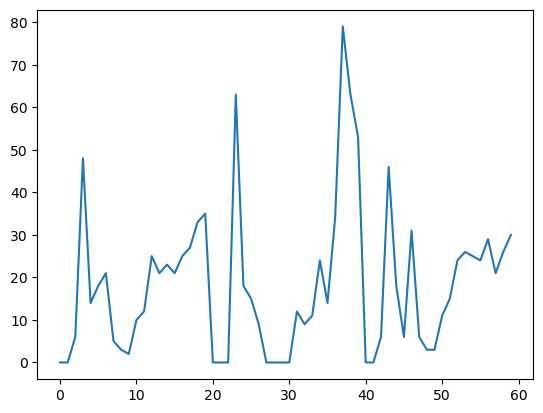

In [17]:
def calc_fingerprint(material_id, fingerprint_length, e_range=[-8, 8]):
    global edges
    filename_bands=DATA_PATH+"/bands/"+material_id+'.json'
    if not os.path.isfile(filename_bands):
        print("!!!! No such file %s" % filename_bands)
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]
        # print(i, branch_energies)
        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range)
        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint
    

fp = calc_fingerprint("2dm-1", 60)
plt.plot(fp)
fp

In [18]:
# re-run with all materials using this line
#flat_df = material_df

fingerprint_length = 85
finger_print_array = np.zeros([len(flat_df), fingerprint_length])

In [19]:
for i, material_id in enumerate(flat_df.index):
    if i % 100 == 0:
        print(i, "/", len(flat_df))

    finger_print_array[i, :] = calc_fingerprint(material_id, fingerprint_length)

print(finger_print_array)

0 / 2005
100 / 2005
200 / 2005
300 / 2005
400 / 2005
500 / 2005
600 / 2005
700 / 2005
800 / 2005
900 / 2005
1000 / 2005
1100 / 2005
1200 / 2005
1300 / 2005
1400 / 2005
1500 / 2005
1600 / 2005
1700 / 2005
1800 / 2005
1900 / 2005
2000 / 2005
[[ 42.   0.  21. ...   0.   0.   0.]
 [  0.  42.  44. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.  21.  82. ...  52.  30.   0.]
 [104.  98.   8. ...  13.   0.   0.]
 [  0.   0.  18. ...  49.  20.   0.]]


In [20]:
df = flat_df.join(pd.DataFrame(finger_print_array, index=flat_df.index))
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,decomp_eng,band_gap,...,73,74,75,76,77,78,79,80,81,82,83,84
ID,,,,,,,,,,,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,1,3,0.095794,0.177410,0.9814,...,47.0,57.0,55.0,89.0,106.0,133.0,67.0,7.0,0.0,0.0,0.0,0.0
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,1,1,0.097255,0.231110,0.0000,...,23.0,42.0,45.0,67.0,59.0,68.0,77.0,28.0,0.0,0.0,0.0,0.0
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,1,4,0.037593,0.187980,1.9866,...,18.0,32.0,39.0,31.0,38.0,33.0,9.0,0.0,0.0,0.0,0.0,0.0
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,1,2,0.140290,0.058544,0.0000,...,38.0,30.0,39.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,1,3,0.067035,0.035965,1.8022,...,41.0,1.0,0.0,16.0,104.0,98.0,163.0,147.0,60.0,0.0,0.0,0.0


In [21]:
#check for NaNs 
np.isnan(finger_print_array).sum()

0

In [22]:
df.isna().sum()[ df.isna().sum() != 0 ]

exfoliation_eg     606
decomp_eng          47
B                   10
C                 1124
D                 1752
E                 2005
F                 2005
dtype: int64

In [23]:
# save df
df.to_csv("materials_data_all_k_branches_fingerprint_85.csv")

## Clustering

In [5]:
df = pd.read_csv("materials_data_all_k_branches_fingerprint_60.csv")
fingerprint_length = 60
fingerprint_cols = [str(i) for i in range(fingerprint_length)]
fingerprint_array = df[fingerprint_cols]

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=4, p=0.2)
clusterer.fit(fingerprint_array)

labels = clusterer.labels_
df["labels"] = labels
print(np.unique(labels, return_counts=True))
df[df.labels==1].head(19)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40], dtype=int64), array([1710,    8,    5,   14,    7,    6,    5,    7,    4,    6,    6,
          5,    4,    5,    6,    7,    5,    9,    5,    5,    7,    8,
          9,    6,   11,    9,    4,    5,    5,    6,    4,    4,    8,
          8,   12,    4,   14,    5,    4,    6,   29,    8], dtype=int64))


,ID,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,decomp_eng,...,49,50,51,52,53,54,55,56,57,58,59,labels
233,2dm-900,Ga2Te,AB2,143,3,3,0.78315,bottom-up,1,3,NaN,0.25942,...,212.0,183.0,157.0,212.0,317.0,398.0,224.0,0.0,0.0,0.0,0.0,1
236,2dm-903,Ga2Te,AB2,143,3,3,0.81656,bottom-up,1,3,0.22261,0.25806,...,209.0,189.0,158.0,219.0,319.0,390.0,219.0,0.0,0.0,0.0,0.0,1
240,2dm-910,Ga2Se,AB2,143,3,3,0.87920,bottom-up,1,3,0.19680,0.27344,...,203.0,144.0,162.0,227.0,332.0,343.0,276.0,0.0,0.0,0.0,0.0,1
522,2dm-1777,Ga2S,AB2,143,3,3,0.87920,bottom-up,1,3,0.14644,0.29770,...,218.0,95.0,155.0,236.0,304.0,319.0,309.0,91.0,0.0,0.0,0.0,1
531,2dm-1794,Ga2S,AB2,143,3,3,0.84263,bottom-up,1,4,0.15704,0.30003,...,214.0,98.0,161.0,256.0,285.0,331.0,305.0,70.0,0.0,0.0,0.0,1


In [6]:
from ipywidgets import interact

def view_cluster(label):
    display(df[df.labels==label].head(100))

    num_plots = len(df[df.labels==label])

    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        # ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])?
        ax[i].plot(np.linspace(-8, 8, fingerprint_length), df.loc[index][fingerprint_cols])


    
    
interact(view_cluster, label=(-1, len(np.unique(labels))-2, 1))

interactive(children=(IntSlider(value=19, description='label', max=40, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

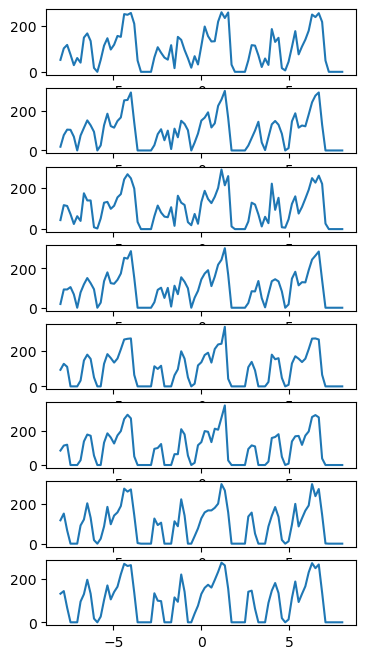

In [27]:
label = 1
num_plots = len(df[df.labels==label])

fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

for i, index in enumerate(df[df.labels==label].index):
    # ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])?
    ax[i].plot(np.linspace(-8, 8, fingerprint_length), df.loc[index][fingerprint_cols])

plt.show()

## T-SNE Plot

In [28]:
n_components=2
tsne = manifold.TSNE(n_components=n_components, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
fingerprints_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.001s...
[t-SNE] Computed neighbors for 2005 samples in 0.323s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 134.642348
[t-SNE] Computed conditional probabilities in 0.174s
[t-SNE] Iteration 50: error = 73.4506226, gradient norm = 0.0133883 (50 iterations in 0.545s)
[t-SNE] Iteration 100: error = 72.5710907, gradient norm = 0.0010044 (50 iterations in 0.502s)
[t-SNE] Iteration 150: error = 72.4327850, gradient norm = 0.0027875 (50 iterations in 0.436s)
[t-SNE] Iteration 200: error = 72.2964020, gradient norm = 0.0002765 (50 iterations in 0.460s)
[t-SNE] Iteration 250: error = 72.2883759, gradient norm = 0.0001806 (50 iterations in 0.463s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.288376
[t-SNE] Iteration 300: er

[t-SNE] Iteration 4150: error = 1.1437085, gradient norm = 0.0002480 (50 iterations in 0.502s)
[t-SNE] Iteration 4200: error = 1.1436248, gradient norm = 0.0002907 (50 iterations in 0.459s)
[t-SNE] Iteration 4250: error = 1.1435995, gradient norm = 0.0002200 (50 iterations in 0.507s)
[t-SNE] Iteration 4300: error = 1.1435783, gradient norm = 0.0002144 (50 iterations in 0.506s)
[t-SNE] Iteration 4350: error = 1.1435361, gradient norm = 0.0001480 (50 iterations in 0.570s)
[t-SNE] Iteration 4400: error = 1.1435099, gradient norm = 0.0001736 (50 iterations in 0.559s)
[t-SNE] Iteration 4450: error = 1.1434971, gradient norm = 0.0001504 (50 iterations in 0.585s)
[t-SNE] Iteration 4500: error = 1.1434784, gradient norm = 0.0002106 (50 iterations in 0.549s)
[t-SNE] Iteration 4550: error = 1.1434115, gradient norm = 0.0001910 (50 iterations in 0.519s)
[t-SNE] Iteration 4600: error = 1.1433072, gradient norm = 0.0003419 (50 iterations in 0.536s)
[t-SNE] Iteration 4650: error = 1.1432723, gradien

[t-SNE] Iteration 8500: error = 1.1417170, gradient norm = 0.0001656 (50 iterations in 0.588s)
[t-SNE] Iteration 8550: error = 1.1416967, gradient norm = 0.0001099 (50 iterations in 0.616s)
[t-SNE] Iteration 8600: error = 1.1416659, gradient norm = 0.0003568 (50 iterations in 0.545s)
[t-SNE] Iteration 8650: error = 1.1416780, gradient norm = 0.0001375 (50 iterations in 0.545s)
[t-SNE] Iteration 8700: error = 1.1416695, gradient norm = 0.0001247 (50 iterations in 0.574s)
[t-SNE] Iteration 8750: error = 1.1416682, gradient norm = 0.0001278 (50 iterations in 0.561s)
[t-SNE] Iteration 8800: error = 1.1416686, gradient norm = 0.0001137 (50 iterations in 0.567s)
[t-SNE] Iteration 8850: error = 1.1416763, gradient norm = 0.0001542 (50 iterations in 0.514s)
[t-SNE] Iteration 8900: error = 1.1416116, gradient norm = 0.0001552 (50 iterations in 0.535s)
[t-SNE] Iteration 8950: error = 1.1416264, gradient norm = 0.0001546 (50 iterations in 0.604s)
[t-SNE] Iteration 9000: error = 1.1416078, gradien

C:\Users\hkpen\AppData\Local\Temp\ipykernel_12008\3318175735.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('turbo')


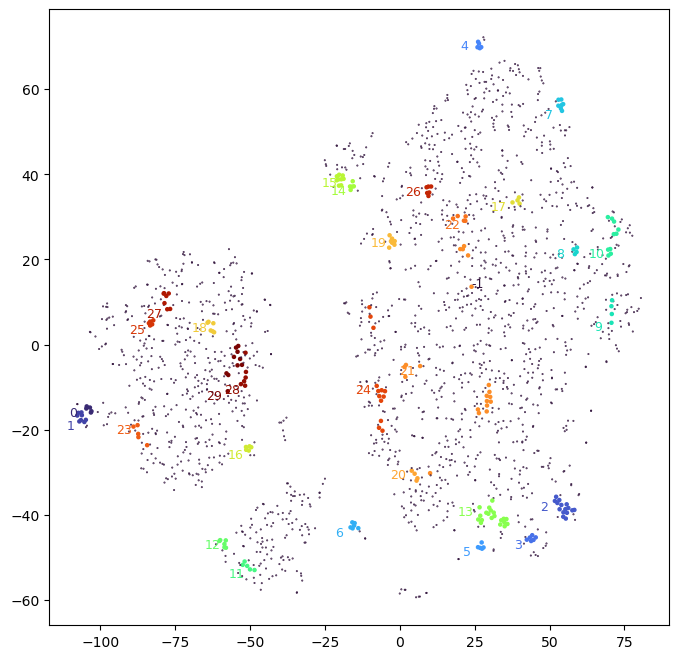

In [30]:
fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprints_2d[rep_id,:]+[-4.5,-1],color=col,alpha=1, weight='normal', ha='center', va='center', size=9).draggable()

plt.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=size, c=labels*5, cmap="turbo")

<Axes: ylabel='$\\lambda$ value'>

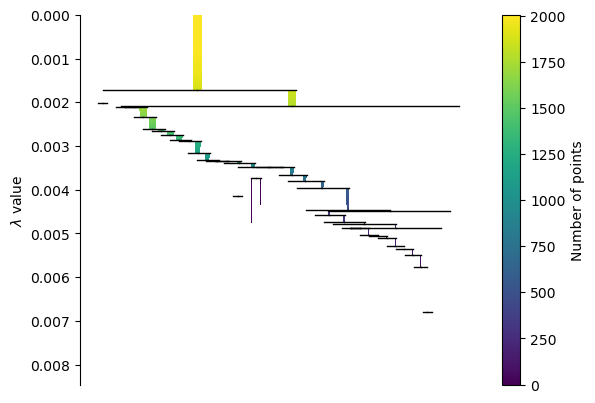

In [30]:
clusterer.condensed_tree_
clusterer.condensed_tree_.plot()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.001s...
[t-SNE] Computed neighbors for 2005 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 165.883147
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.255951
[t-SNE] KL divergence after 300 iterations: 1.839144


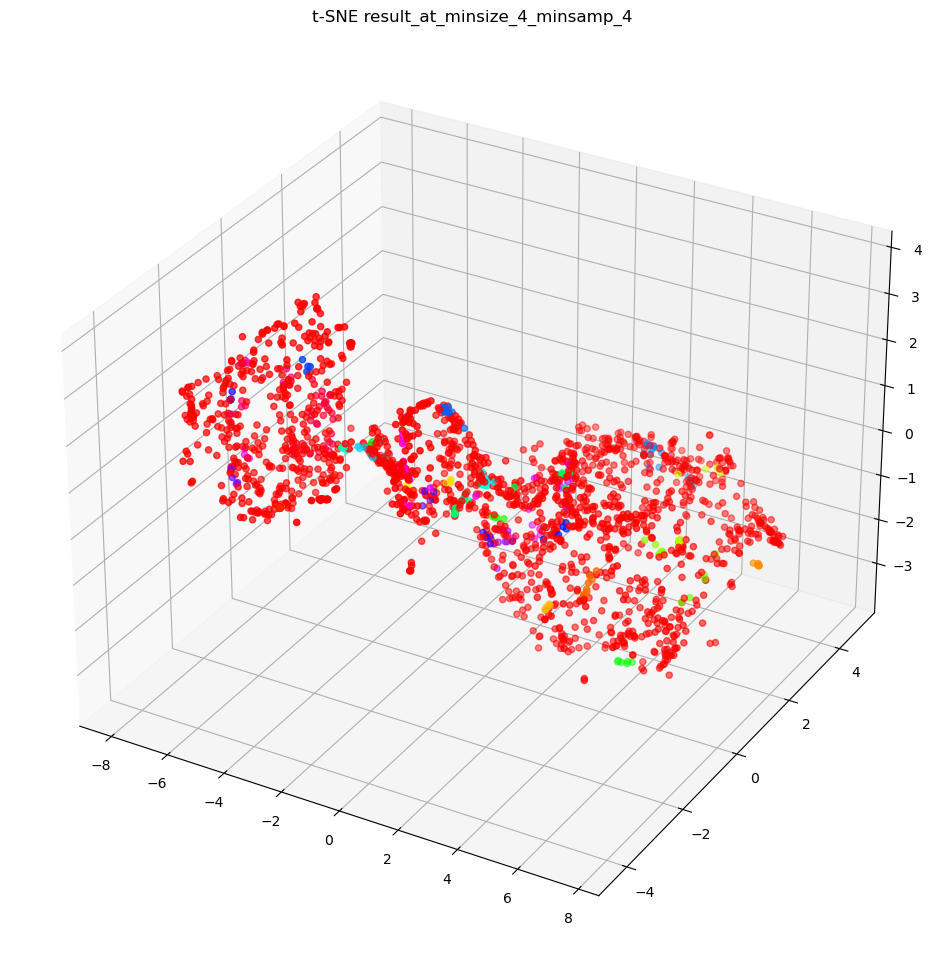

In [18]:
###################################
######### tSNE visualization 3D 
min_size=4
min_samp=4

tsne=manifold.TSNE(n_components=3, verbose=1, perplexity=50, n_iter=300)
ts= tsne.fit_transform(fingerprint_array)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
########
##### for different eps
# for i in np.arange(0.025,0.31,0.025):
#     eps=round(i, 3)
#     label=db.single_linkage_tree_.get_clusters(eps, min_cluster_size=3)
#     n_clusters_ = label.max()
#     n_noise_ = list(label).count(-1)
#     print(str(eps)+' '+str(len(labels))+' '+str(n_clusters_)+' '+str(n_noise_)+' '+str(metrics.silhouette_score(X, label)))
#     ax.scatter(ts[:,0], ts[:,1], ts[:,2], c=labels+1, cmap="hsv")
#     fname="t-SNE result_at_eps"+str(eps)
#     plt.title(fname)
#     plt.savefig(fname+'.png', bbox_inches='tight')
#     plt.show()
###########
###### for current minsize and minsamples
ax.scatter(ts[:,0], ts[:,1], ts[:,2], c=labels+1, cmap="hsv")
fname="t-SNE result_at_minsize_"+str(min_size)+"_minsamp_"+str(min_samp)
plt.title(fname)
plt.savefig(fname+'.png', bbox_inches='tight')
plt.show()